# Traffic Sign Classification

This notebook will classify traffic signs using deep learning models.

## About the Dataset
There are around 58 classes and each class has around 120 images. The labels.csv file has the respective description of the traffic sign class.

The 58 classes are:

|Class | Label |
| -----|------- |
|0  | Speed limit (5km/h) |
|1  | Speed limit (15km/h) |
|2  | Speed limit (30km/h) |
|3  | Speed limit (40km/h) |
|4  | Speed limit (50km/h) |
|5  | Speed limit (60km/h) |
|6  | Speed limit (70km/h) |
|7  | speed limit (80km/h) |
|8  | Dont Go straight or left |
|9  | Dont Go straight or Right |
|10 | Dont Go straight |
|11 | Dont Go Left |
|12 | Dont Go Left or Right |
|13 | Dont Go Right |
|14 | Dont overtake from Left |
|15 | No Uturn |
|16 | No Car |
|17 | No horn |
|18 | Speed limit (40km/h) |
|19 | Speed limit (50km/h) |
|20 | Go straight or right |
|21 | Go straight |
|22 | Go Left |
|23 | Go Left or right |
|24 | Go Right |
|25 | keep Left |
|26 | keep Right |
|27 | Roundabout mandatory |
|28 | watch out for cars |
|29 | Horn |
|30 | Bicycles crossing |
|31 | Uturn |
|32 | Road Divider |
|33 | Traffic signals |
|34 | Danger Ahead |
|35 | Zebra Crossing |
|36 | Bicycles crossing |
|37 | Children crossing |
|38 | Dangerous curve to the left |
|39 | Dangerous curve to the right |
|40 | Unknown1 |
|41 | Unknown2 |
|42 | Unknown3 |
|43 | Go right or straight |
|44 | Go left or straight |
|45 | Unknown4 |
|46 | ZigZag Curve |
|47 | Train Crossing |
|48 | Under Construction |
|49 | Unknown5 |
|50 | Fences |
|51 | Heavy Vehicle Accidents |
|52 | Unknown6 |
|53 | Give Way |
|54 | No stopping |
|55 | No entry |
|56 | Unknown7 |
|57 | Unknown8 |

## Main Objective

The main objective of this project is to identify the type of traffic sign from the image and classify the image within one of the above classes. The accuracy of the classification will be measured by the number of correct classifications out of the total amount of images in each class.

In [1]:
import os
import pandas as pd 
import numpy as np
import sys
import glob
import tensorflow as tf 
import keras 
from tensorflow.keras import layers, models, backend
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

<Axes: xlabel='label', ylabel='count images'>

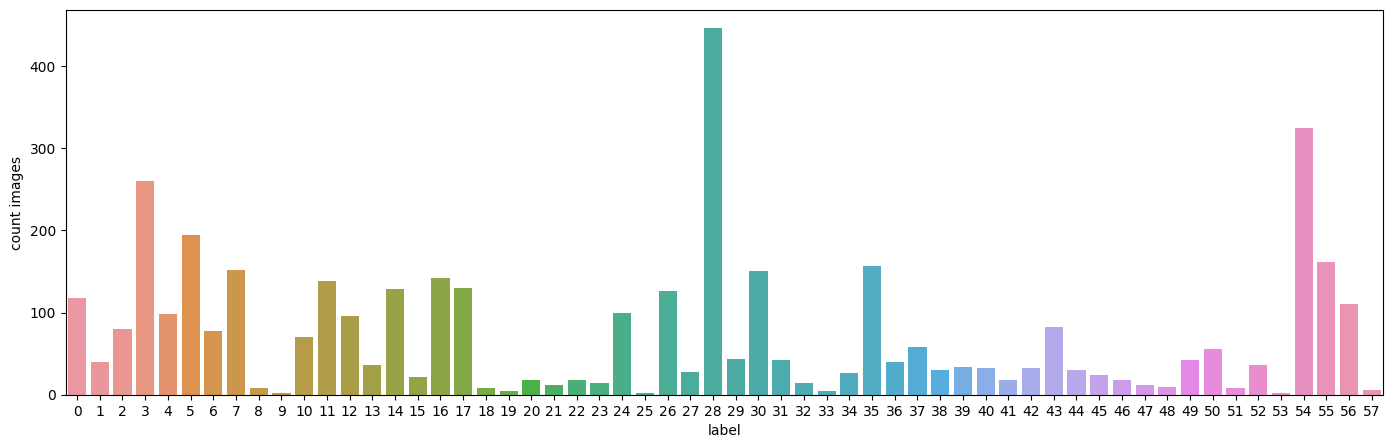

In [2]:
image_paths = list(Path('../input/traffic-sign-dataset-classification/traffic_Data/DATA').glob(r'**/*.png'))
labels = list(map(lambda path: os.path.split(os.path.split(path)[0])[1], image_paths))

images = pd.Series(image_paths).astype(str)
labels = pd.Series(labels).astype(str)
frame = {'image':images, 'label':labels}
image_df = pd.DataFrame(frame)

count_labels = image_df.groupby(['label']).size()
count_labels.index=count_labels.index.astype(int)
count_labels = count_labels.sort_index()
count_labels.index=count_labels.index.astype(str)
plt.figure(figsize=(17,5))
plt.ylabel('count images')
sns.barplot(x=count_labels.index, y=count_labels)


In [3]:
## batch specification
batch_size = 64
img_height = 224
img_width = 224
SEED = 4
SPLIT_MINIMUM_COUNT = 10
EPOCH = 50

## Checkpoints
vgg16_checkpoint_path=r'/kaggle/working/O_R_tlearn_image_augm_cnn_vgg16.keras'

In [4]:
def split_dataset(df, rate=SPLIT_MINIMUM_COUNT):
    count_labels = df.groupby(['label']).size()
    count_labels_df = count_labels.to_frame(name='count_images').reset_index()
    
    drop_label_list = list(
          count_labels_df['label'].\
          loc[count_labels_df['count_images']<SPLIT_MINIMUM_COUNT]
      )
    
    drop_df = df.copy()
    split_df = df.copy()
    
    for index, row in df.iterrows():
        if str(row.label) in drop_label_list:
          split_df = split_df.drop(index)
        else:
          drop_df = drop_df.drop(index)
    
    return split_df, drop_df

def custom_train_test_split(df):
    labels = df.label.unique()
    test_df = pd.DataFrame()
    
    for label in labels:
        label_samples = df.loc[df.label==label]
        test_df = pd.concat([test_df, label_samples.sample(len(label_samples)//10+1,
                               random_state=SEED)])
        
        train_df = df.drop(list(test_df.index), axis=0)
        test_df = test_df.sample(frac=1, random_state=SEED)
        train_df = train_df.sample(frac=1, random_state=SEED)
    
    return train_df, test_df

In [5]:
split_df, _ = split_dataset(image_df)
train_df, test_df = custom_train_test_split(split_df)
train, val = custom_train_test_split(train_df)
train_labels = train_df.groupby(['label']).size()
NUM_CLASSES = len(train_labels)

## Deep Learning Models

The traffic signs will be classified with the following models:

1. AlexNet
2. VGG16
3. ResNet

Transfer learning will be used with each model to classify the 58 traffic sign classes. Each model will be evaluated by its accuracy to determine the best model.

Define Early Stopping functions to prevent over fitting.

In [6]:
split_df, _ = split_dataset(image_df)
train_df, test_df = custom_train_test_split(split_df)
train, val = custom_train_test_split(train_df)

In [7]:
## loading training set
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                                                                  rescale=1./255,
                                                                  rotation_range=10,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  shear_range=0.15,
                                                                  zoom_range=0.15,
                                                                  horizontal_flip=False,
                                                                  vertical_flip=False,
                                                                  fill_mode='constant',
                                                                  validation_split=0.3
                                                                  )
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                    x_col='image',
                                                    y_col='label',
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=SEED,
                                                )

## loading testing data
val_images = test_generator.flow_from_dataframe(dataframe=val,
                                                x_col='image',
                                                y_col='label',
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=SEED,
                                            )

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                    x_col='image',
                                                    y_col='label',
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                )


Found 3683 validated image filenames belonging to 49 classes.
Found 396 validated image filenames belonging to 49 classes.
Found 443 validated image filenames belonging to 49 classes.


In [8]:
# define step decay function
class LossHistory_(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-5
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

### VGG16

In [9]:
from keras.applications import vgg16

keras_callbacks = [
      EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01),
    ModelCheckpoint(vgg16_checkpoint_path, monitor='loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_, keras_callbacks]

basemodel = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=(img_height, img_width, 3)
                       )

basemodel.trainable = False
for layer in basemodel.layers:
    layer.trainable = False

# input_shape = basemodel.output_shape
inputs = Input(shape=(img_height, img_width, 3))

# model = Sequential()
x = basemodel(inputs, training=False)
x = Flatten()(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs) 

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

vgg16_history = model.fit(train_images,
                           epochs=EPOCH,
                           validation_data=val_images,
                           callbacks=callbacks_list_)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0833 - loss: 3.8073lr: 9.048374180359596e-06
58/58 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.0836 - loss: 3.8037 - val_accuracy: 0.1086 - val_loss: 19.4150 - learning_rate: 1.0000e-05
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.2182 - loss: 3.1512lr: 8.18730753077982e-06
58/58 ━━━━━━━━━━━━━━━━━━━━ 46s 702ms/step - accuracy: 0.2187 - loss: 3.1497 - val_accuracy: 0.2096 - val_loss: 15.5807 - learning_rate: 9.0484e-06
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.3095 - loss: 2.8235lr: 7.408182206817179e-06
58/58 ━━━━━━━━━━━━━━━━━━━━ 46s 703ms/step - accuracy: 0.3096 - loss: 2.8227 - val_accuracy: 0.2702 - val_loss: 12.8669 - learning_rate: 8.1873e-06
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.3812 - loss: 2.5812lr: 6.703200460356394e-06
58/58 ━━━━━━━━━━━━━━━━━━━━ 47s 717ms/step - accuracy: 0.3814 - loss: 2.5809 - val_accuracy: 0.3561 - val_loss: 11.0930 - learning_rat

In [10]:
# test_dir = r"/kaggle/input/traffic-sign-dataset-classification/traffic_Data/TEST/"
# image_files = os.listdir(test_dir)

# # Extract image names and class labels
# data = [(file, int(file[:3])) for file in image_files]

# # Create DataFrame
# true_labels_df = pd.DataFrame(data, columns=['Path', 'ClassId'])
# true_labels_df['Path']=test_dir + '/' + true_labels_df['Path']
# true_labels_df['ClassId'] = true_labels_df['ClassId'].astype(str)


# # test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
# #     preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
# # )

# test_gen=train_generator.flow_from_dataframe(true_labels_df, x_col='Path', y_col='ClassId', target_size=(img_height, img_width), class_mode='categorical',
#                                     color_mode='rgb', shuffle=False, batch_size=batch_size)

In [11]:
# vgg16_preds=model.predict(test_images, verbose=1) 

# predicted_labels = np.argmax(vgg16_preds, axis=1)

# predicted_labels = predicted_labels.astype(str)
# # True labels from the DataFrame
# # true_labels = true_labels_df['ClassId'].values
# true_labels = test_df['label'].values

# Calculate accuracy
# correct_predictions = np.sum(mapped_predictions == true_labels)
# correct_predictions = np.sum(predicted_labels == true_labels)
# accuracy = correct_predictions / len(true_labels)

# # Print the accuracy
# print(f"Accuracy: {accuracy:.4f}")


In [12]:
true_labels = []
for _, labels in test_images:
    true_labels.extend(np.argmax(labels, axis=1))
    if len(true_labels) >= test_images.samples:
        break  # Stop when all samples are processed

true_labels = np.array(true_labels)

In [13]:
pred_probs = model.predict(test_images)  # Get probability outputs
pred_labels = np.argmax(pred_probs, axis=1)  # Convert to class indices

7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step


In [14]:
correct_predictions = np.sum(pred_labels == true_labels)
accuracy = correct_predictions / len(true_labels)

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6569


In [15]:
class_names = list(test_images.class_indices.keys())
clr = classification_report(true_labels, pred_labels, target_names=class_names, zero_division=0.0)
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.18      1.00      0.30        12
           1       0.00      0.00      0.00         5
          10       0.71      0.62      0.67         8
          11       1.00      0.71      0.83        14
          12       0.43      1.00      0.61        10
          13       0.00      0.00      0.00         4
          14       1.00      0.62      0.76        13
          15       0.00      0.00      0.00         3
          16       0.83      0.67      0.74        15
          17       0.77      0.71      0.74        14
           2       0.20      0.11      0.14         9
          20       1.00      1.00      1.00         2
          21       0.00      0.00      0.00         2
          22       1.00      0.50      0.67         2
          23       0.00      0.00      0.00         2
          24       0.83      0.91      0.87        11
          26       0.92      0.85 

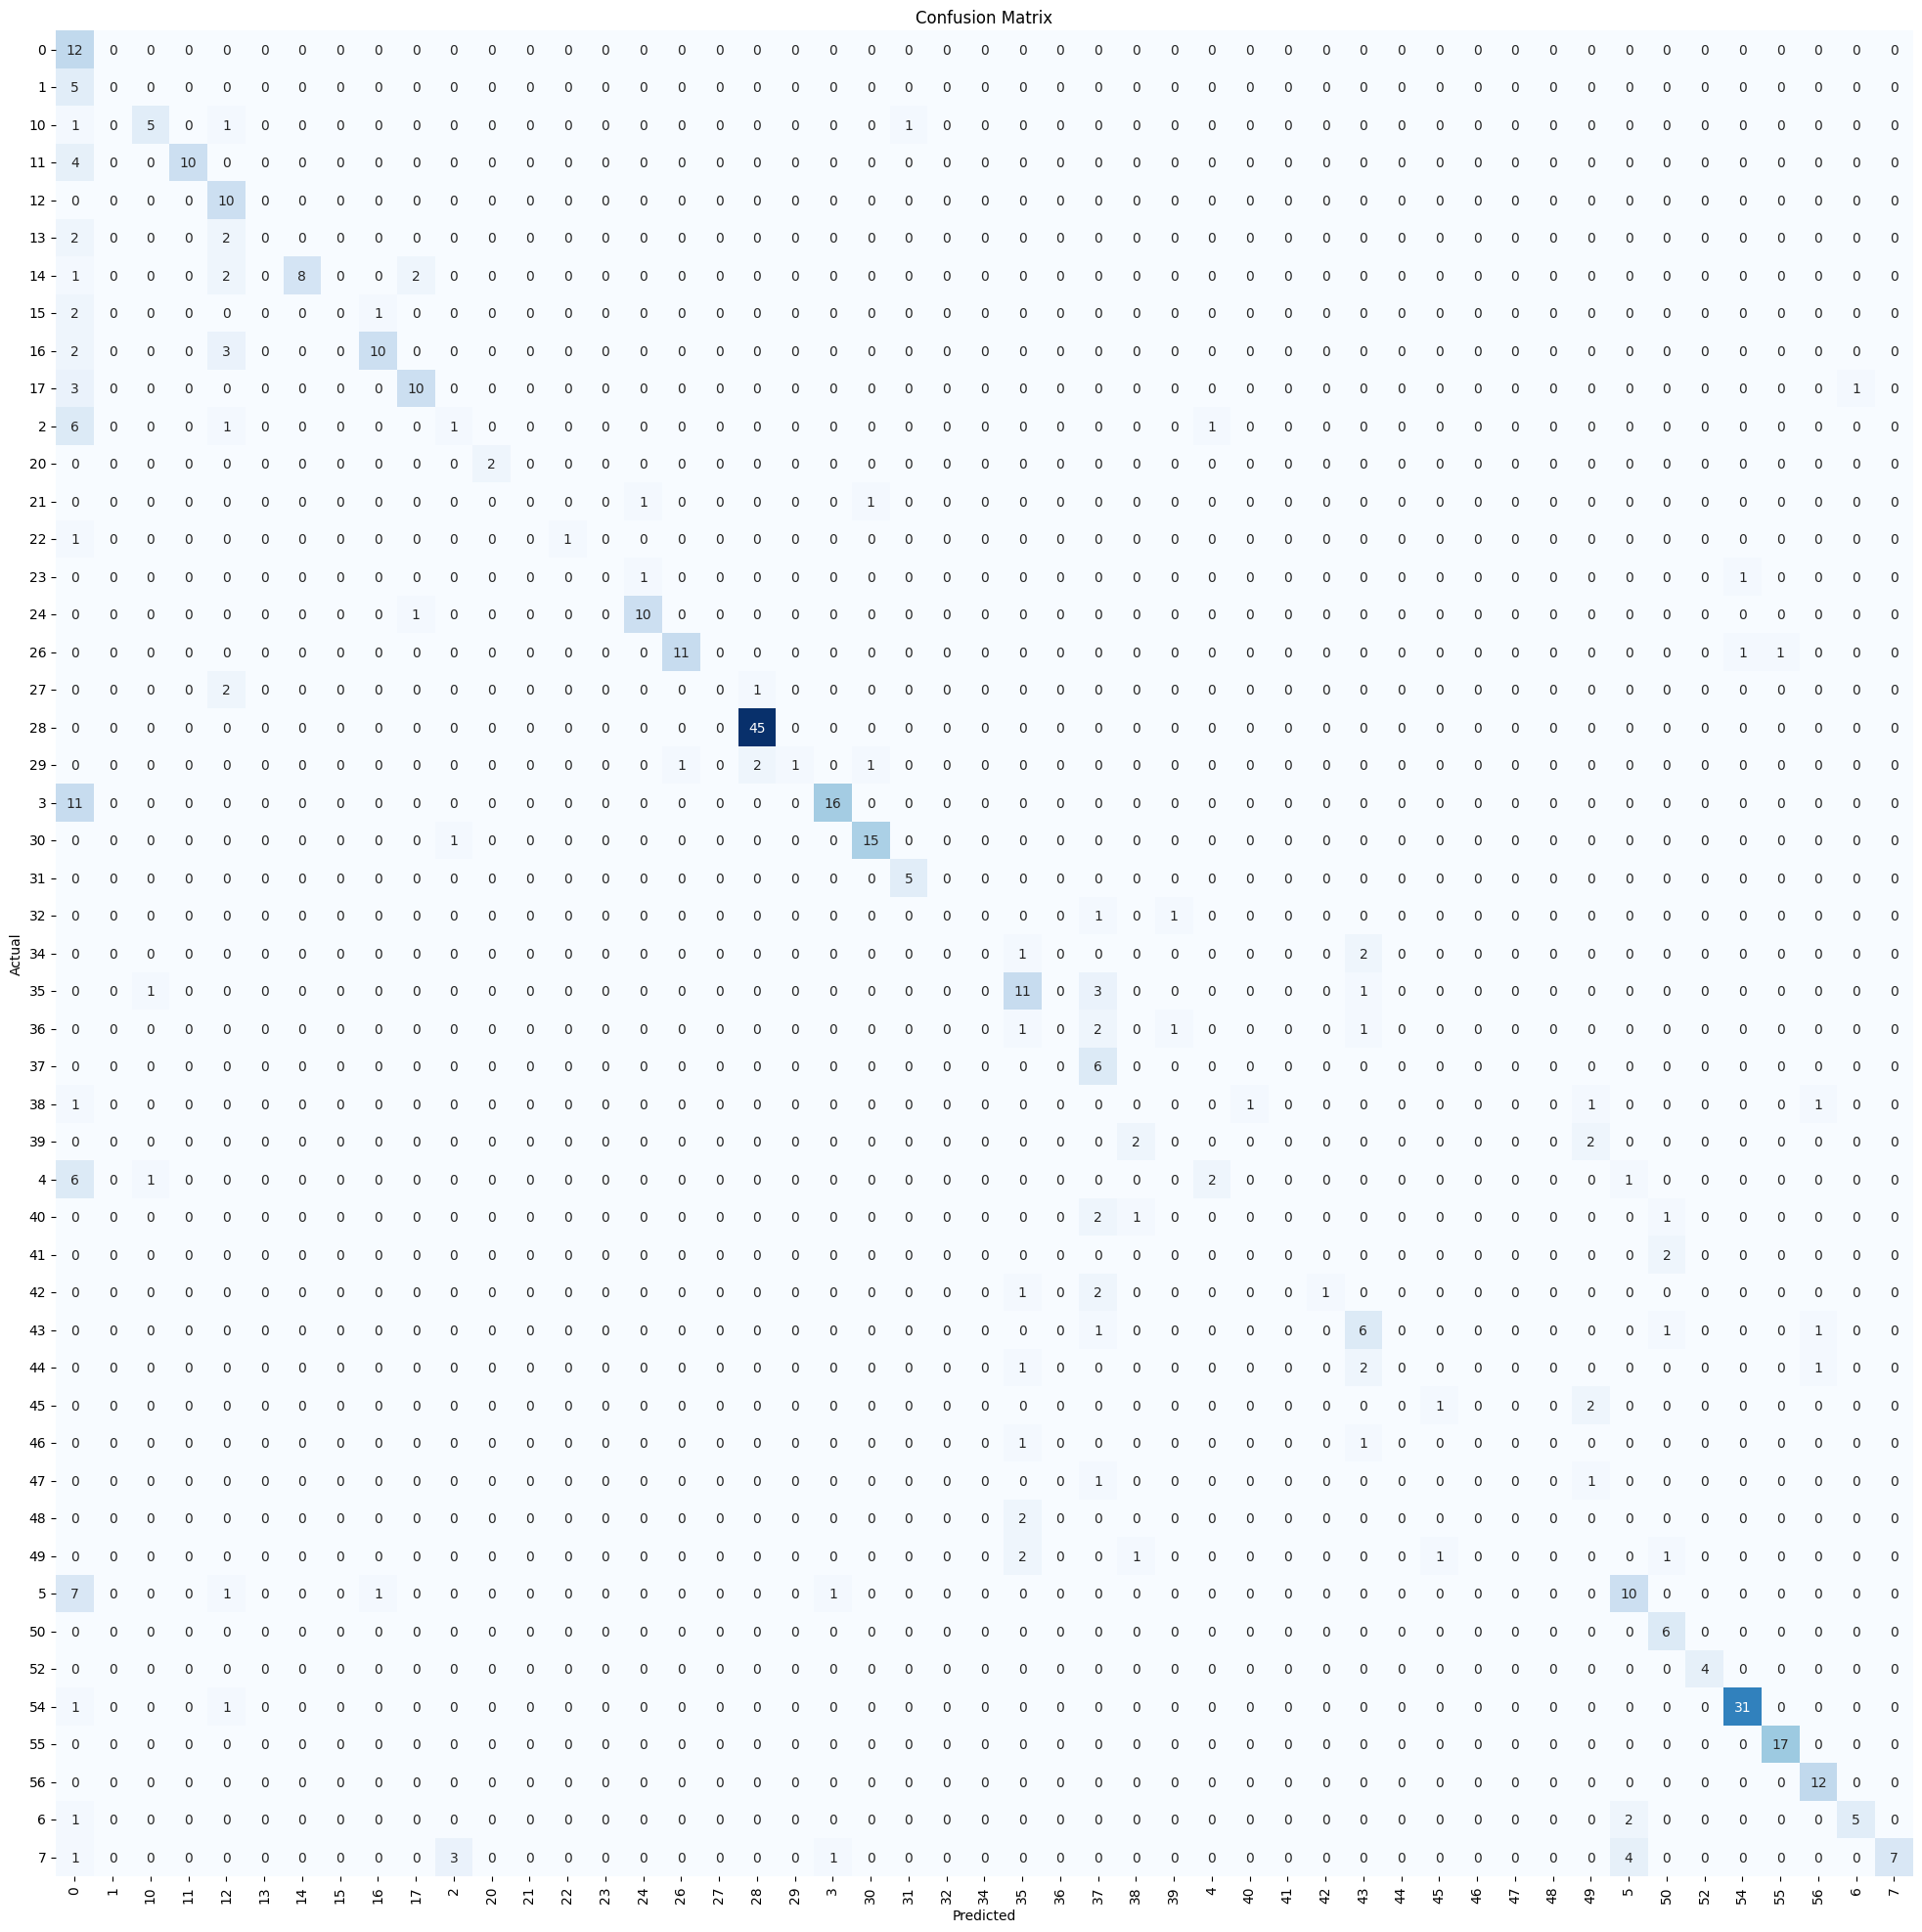

In [16]:
cm = confusion_matrix(true_labels, pred_labels)  
fig_width = len(class_names) * 0.5
fig_height = len(class_names) * 0.5
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(len(class_names))+.5, class_names, rotation= 90)
plt.yticks(np.arange(len(class_names))+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()